In [52]:
from pathlib import Path
from datetime import date
import pandas as pd, matplotlib.pyplot as plt
from google.cloud import bigquery

# --- Konfiguracija ---
PROJECT_ID = "charged-city-421819"
OWN_REGION = "EU"  # tvoj BQ region
COUNTRIES  = ["Serbia", "Norway", "Germany"]

client = bigquery.Client(project=PROJECT_ID)
pd.options.display.float_format = "{:,.2f}".format

# Find bq/sql bez regardless where it is run from
def find_sql_dir() -> Path:
    candidates = [Path("bq/sql"), Path("../bq/sql"), Path("../../bq/sql"), Path("notebook/bq/sql")]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError("Nisam našla bq/sql folder (proveri putanju u repou).")
SQL_DIR = find_sql_dir()

# Izvrši SQL with automatic choice of location (US for public, else your region)
def run_sql(q: str, params: dict | None = None) -> pd.DataFrame:
    job = bigquery.QueryJobConfig()
    if params:
        job.query_parameters = [
            bigquery.ScalarQueryParameter(k, "DATE", v) if isinstance(v, date)
            else bigquery.ScalarQueryParameter(k, "STRING", str(v))
            for k, v in params.items()
        ]
    loc = "US" if "bigquery-public-data" in q else OWN_REGION
    return client.query(q, job_config=job, location=loc).result().to_dataframe()

def read_sql(name: str) -> str:
    return (SQL_DIR / name).read_text(encoding="utf-8")

# Simple plots 
def plot_ma7(df: pd.DataFrame):
    s = df[df["country_name"].isin(COUNTRIES)].copy()
    s["date"] = pd.to_datetime(s["date"])
    p = s.pivot(index="date", columns="country_name", values="new_cases_7d_avg")
    ax = p.plot(figsize=(9,4)); ax.set(title="New cases (7-day MA)", xlabel="Date", ylabel="Cases"); plt.tight_layout()

def plot_incidence(df: pd.DataFrame):
    s = df[df["country_name"].isin(COUNTRIES)].copy()
    s["date"] = pd.to_datetime(s["date"])
    p = s.pivot(index="date", columns="country_name", values="new_per_100k_7d_avg")
    ax = p.plot(figsize=(9,4)); ax.set(title="New cases per 100k (7-day MA)", xlabel="Date", ylabel="Per 100k"); plt.tight_layout()

# Output folder (radi iz bilo kog mesta)
def find_out_dir() -> Path:
    for p in [Path("../outputs"), Path("../../outputs"), Path("./outputs")]:
        try:
            p.mkdir(parents=True, exist_ok=True)
            return p
        except Exception:
            pass
    raise OSError("Ne mogu da kreiram outputs folder.")
OUT_DIR = find_out_dir()

print("SQL_DIR:", SQL_DIR.resolve())
print("OUT_DIR:", OUT_DIR.resolve())
print("Project:", client.project, "| Default (own) region:", OWN_REGION)

SQL_DIR: /home/paunica/projects/covid19-analysis/bq/sql
OUT_DIR: /home/paunica/projects/covid19-analysis/outputs
Project: charged-city-421819 | Default (own) region: EU


In [53]:
df_covid = run_sql(read_sql("01_daily_7d_avg_owid.sql"))
df_inc_7d = run_sql(read_sql("02_incidence_7d_owid.sql"))
target_date = date(2021, 12, 1)
df_top10 = run_sql(read_sql("03_top10_incidence_owid.sql"), {"target_date": target_date})
df_peak  = run_sql(read_sql("04_peak_date_owid.sql"))


,date,country_name,new_cases,new_cases_7d_avg
0,2020-03-01,Germany,0.00,0.00
1,2020-03-02,Germany,0.00,0.00
2,2020-03-03,Germany,0.00,0.00
3,2020-03-04,Germany,0.00,0.00
4,2020-03-05,Germany,0.00,0.00


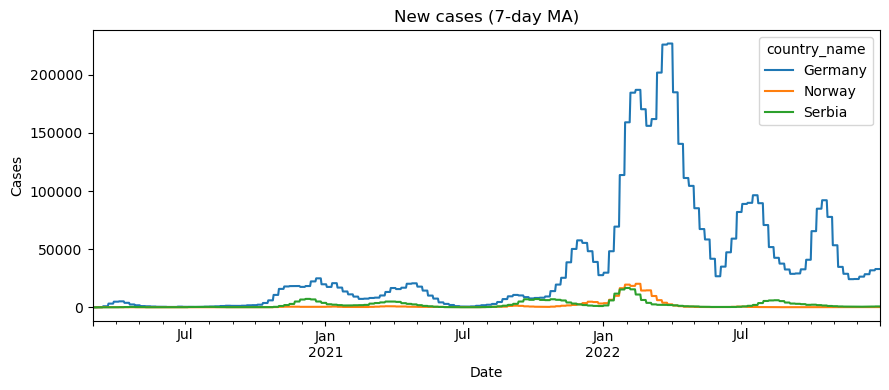

In [54]:
df_covid = run_sql(read_sql("01_daily_7d_avg_owid.sql"))
plot_ma7(df_covid)
df_covid.head()

,date,country_name,new_per_100k,new_per_100k_7d_avg
0,2020-03-01,Germany,0.00,0.00
1,2020-03-02,Germany,0.00,0.00
2,2020-03-03,Germany,0.00,0.00
3,2020-03-04,Germany,0.00,0.00
4,2020-03-05,Germany,0.00,0.00


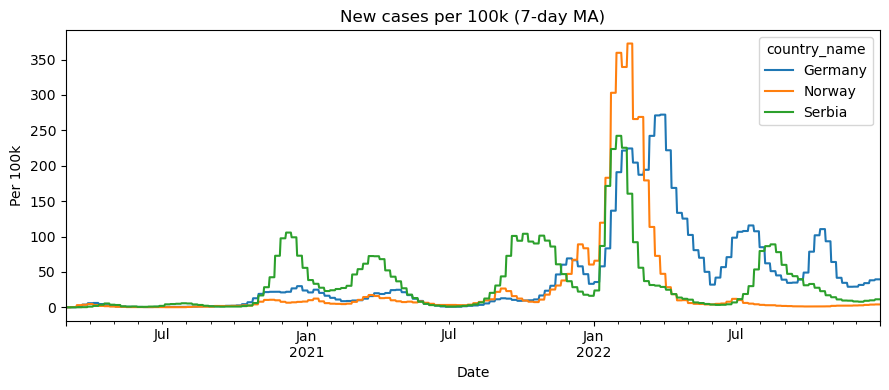

In [55]:
df_inc_7d = run_sql(read_sql("02_incidence_7d_owid.sql"))
plot_incidence(df_inc_7d)
df_inc_7d.head()

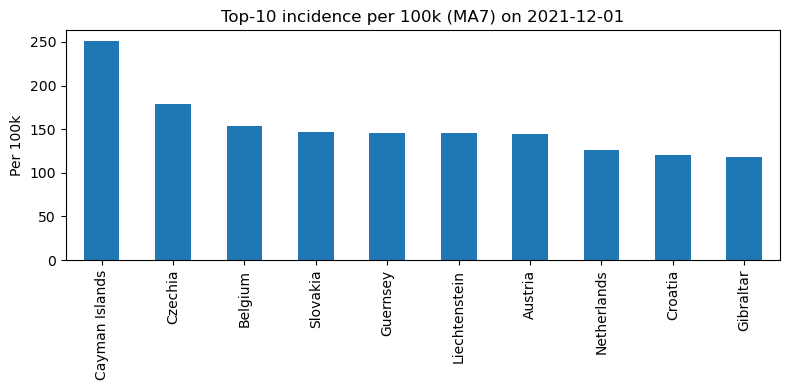

In [56]:
ax = (df_top10
      .head(10)
      .plot(kind="bar", x="country_name", y="new_per_100k_7d",
            figsize=(8,4), legend=False))
ax.set_title(f"Top-10 incidence per 100k (MA7) on {target_date.isoformat()}")
ax.set_xlabel("")
ax.set_ylabel("Per 100k")
plt.tight_layout(); plt.show()

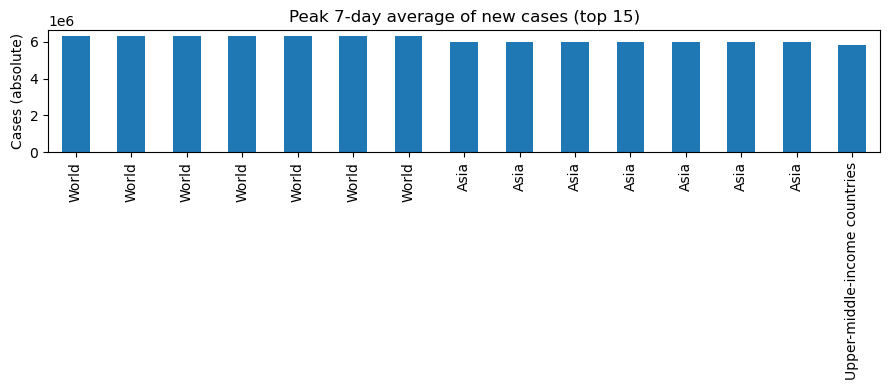

In [57]:
df_peak_plot = df_peak.sort_values("peak_new_7d", ascending=False).head(15)
ax = df_peak_plot.plot(kind="bar", x="country_name", y="peak_new_7d",
                       figsize=(9,4), legend=False)
ax.set_title("Peak 7-day average of new cases (top 15)")
ax.set_xlabel("")
ax.set_ylabel("Cases (absolute)")
plt.tight_layout(); plt.show()

In [58]:
target_date = date(2021, 12, 1)  # change as you wish
df_top10 = run_sql(read_sql("03_top10_incidence_owid.sql"), {"target_date": target_date})
df_top10.head(10)

,country_name,new_per_100k_7d
0,Cayman Islands,250.70
1,Czechia,178.44
2,Belgium,153.50
3,Slovakia,146.37
4,Guernsey,145.72
5,Liechtenstein,145.20
6,Austria,144.91
7,Netherlands,125.70
8,Croatia,120.01
9,Gibraltar,118.48


In [59]:
df_peak = run_sql(read_sql("04_peak_date_owid.sql"))
df_peak.head(15)

,country_name,peak_date,peak_new_7d
0,World,2022-12-25,"6,319,461.00"
1,World,2022-12-26,"6,319,461.00"
2,World,2022-12-27,"6,319,461.00"
3,World,2022-12-28,"6,319,461.00"
4,World,2022-12-29,"6,319,461.00"
5,World,2022-12-30,"6,319,461.00"
6,World,2022-12-31,"6,319,461.00"
7,Asia,2022-12-25,"6,020,346.29"
8,Asia,2022-12-26,"6,020,346.29"
9,Asia,2022-12-27,"6,020,346.29"


In [60]:
(df_covid).to_csv(OUT_DIR / "daily_7d_avg.csv", index=False)
df_inc_7d.to_csv(OUT_DIR / "incidence_7d.csv", index=False)
df_top10.to_csv(OUT_DIR / f"top10_incidence_{target_date.isoformat()}.csv", index=False)
df_peak.to_csv(OUT_DIR / "peak_dates.csv", index=False)
print("Saved CSVs to", OUT_DIR)

Saved CSVs to ../outputs


In [61]:
for n in ["df_covid","df_inc_7d","df_top10","df_peak"]:
    print(n, "OK" if n in globals() else "MISSING")

df_covid OK
df_inc_7d OK
df_top10 OK
df_peak OK
